<a href="https://colab.research.google.com/github/katehee/X-ray_pneumonia_classification/blob/master/pneumonia_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
from numpy import asarray
import seaborn as sns
from tqdm import tqdm

import tensorflow as tf
from keras.preprocessing import image
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.tensorflow import balanced_batch_generator
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report,confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from keras.applications.resnet import ResNet50
from keras.applications.densenet import DenseNet121
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.mobilenet_v3 import MobileNetV3

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
train_dir = "/content/drive/MyDrive/Pneumonia/train/"
test_dir = "/content/drive/MyDrive/Pneumonia/test/"
val_dir = "/content/drive/MyDrive/Pneumonia/val/"

#images to 3d-array 
def img_to_array(dir, label, img_size = 128): 
  image_path = dir + str(label.upper()) #folder name is in upper case 
  image_files = os.listdir(os.path.join(dir, str(label.upper())))
  
  #converting pneumonia/normal images to array 
  images = []
  b_images, v_images = [], [] 
  for image_file in tqdm(image_files): 
    image = cv2.imread(os.path.join(image_path, image_file))
    image = cv2.resize(image, (img_size, img_size)) 
    image = image / 255. 
    images.append(image)

    if label == 'pneumonia': 
      if image_file.split('_')[1] == 'bacteria': 
        b_images.append(image)
      elif image_file.split('_')[1] == 'virus': 
        v_images.append(image)
    
  if label == 'normal': 
    return np.array(images)
  
  elif label == 'pneumonia': 
    return np.array(images), np.array(b_images), np.array(v_images)

In [3]:
#convert train images to 3d arrays 
print("===========training set===========")
p_train, b_train, v_train = img_to_array(train_dir, 'pneumonia')
n_train = img_to_array(train_dir, 'normal')
print("normal: ", n_train.shape, "pneumonia:",p_train.shape, "bateria:", b_train.shape, "virus:",v_train.shape)

#convert validation images to 3d arrays 
print("===========validation set===========")
p_val, b_val, v_val = img_to_array(val_dir, 'pneumonia')
n_val = img_to_array(val_dir, 'normal')
print("normal: ", n_val.shape, "pneumonia:",p_val.shape, "bateria:", b_val.shape, "virus:",v_val.shape)

#convert test images to 3d arrays 
print("===========test set===========")
p_test, b_test, v_test = img_to_array(test_dir, 'pneumonia')
n_test = img_to_array(test_dir, 'normal')
print("normal: ", n_test.shape, "pneumonia:",p_test.shape, "bateria:", b_test.shape, "virus:", v_test.shape)

===========training set===========


100%|██████████| 1359/1359 [02:02<00:00, 11.11it/s]


normal:  (1359, 128, 128, 3) pneumonia: (3933, 128, 128, 3) bateria: (2561, 128, 128, 3) virus: (1372, 128, 128, 3)
===========validation set===========


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


normal:  (8, 128, 128, 3) pneumonia: (8, 128, 128, 3) bateria: (8, 128, 128, 3) virus: (0,)
===========test set===========


100%|██████████| 234/234 [00:21<00:00, 10.83it/s]


normal:  (234, 128, 128, 3) pneumonia: (390, 128, 128, 3) bateria: (242, 128, 128, 3) virus: (148, 128, 128, 3)


#Image preprocessing

In [4]:
img_size = 128
batch_size = 32
epoch_size = 15

train_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1)  # randomly shift images vertically (fraction of total height)

test_datagen = ImageDataGenerator()


### Augmented Data

In [5]:
#normal vs pneumonia 
x_train = np.concatenate((p_train, n_train))
y_train = np.concatenate((np.ones(len(p_train)), np.zeros(len(n_train)))) #label [0,1] == [normal, pneumonia]
x_val = np.concatenate((p_val, n_val))
y_val = np.concatenate((np.ones(len(p_val)), np.zeros(len(n_val))))
x_test = np.concatenate((p_test, n_test))
y_test = np.concatenate((np.ones(len(p_test)), np.zeros(len(n_test)))) 

aug_train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)

### Balanced Augmented Data

In [6]:
#balanced augmented data 
#current image dataset is an imbalanced dataset approx. ratio is 3:1 (pneumonia: normal)
#to balance out the data, I applied oversampling which will increase the size of normal images as the size of pneumonia 

#flatten three channels of each image to one array 
reshaped_x_train = x_train.reshape(x_train.shape[0],-1) 

#oversampling
oversample = RandomOverSampler()
oversampled_X, oversampled_y  = oversample.fit_resample(reshaped_x_train , y_train)

# reshaping X back to the first dims
oversampled_X = oversampled_X.reshape(-1,img_size,img_size,3)

print("imbalanced x_train had {} pneumonia and {} normal samples".format(len(p_train), len(n_train)))
print("balanced set now has {} pneumonia and {} normal samples".format(int(sum(oversampled_y)), int(len(oversampled_X) - sum(oversampled_y))))

balanced_train_generator = train_datagen.flow(oversampled_X, oversampled_y, batch_size=batch_size)

imbalanced x_train had 3933 pneumonia and 1359 normal samples
balanced set now has 3933 pneumonia and 3933 normal samples


### Non-augmented Data

In [7]:
raw_train_generator = test_datagen.flow(x_train, y_train, batch_size=batch_size)

In [8]:
val_generator = test_datagen.flow(x_val, y_val, batch_size=batch_size)
test_generator = test_datagen.flow(x_test, y_test, batch_size=len(x_test))

##Augmented image sample 

class:  PNEUMONIA


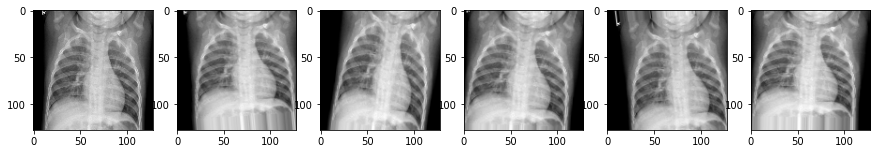

In [9]:
#augmentation of a sample in the training set 
labels =  ['NORMAL','PNEUMONIA']
fig, axes = plt.subplots(1,6,figsize=(15,15))
orig_img = np.array([x_train[0]]) #first image in the training set (original: non-augmented)
axes[0].imshow(orig_img.reshape(img_size,img_size,3), cmap='gray') 
for i in range(5): #display five generated augmented images
  sample, label = train_datagen.flow(orig_img, y_train[:1]).__getitem__(0)
  for img in sample: 
    axes[i+1].imshow(img[:,:,0], cmap='gray')
print("class: ", labels[int(label[0])])

#CNN Modeling

In [10]:
#@title create_plot
def create_plot(history, epoch_size): 
    epochs = [i for i in range(epoch_size)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(12,6)

    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Testing Accuracy & Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

In [12]:
#@title create_model and lr reduction callback
def create_model(): 
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (img_size,img_size,3)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Flatten())
    model.add(Dense(units = 128 , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1 , activation = 'sigmoid'))
    model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
    return model
# model.summary()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.3, min_lr=0.000001)

###with augmented training set


Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 6: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.

Epoch 8: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.

Epoch 10: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.

Epoch 12: ReduceLROnPlateau reducing learning rate to 2.429999949526973e-06.

Epoch 14: ReduceLROnPlateau reducing learning rate to 1e-06.
1/1 [==============================] - 1s 1s/step - loss: 0.3326 - accuracy: 0.9151
Test loss:  0.33263811469078064
Test accuracy 0.9150640964508057


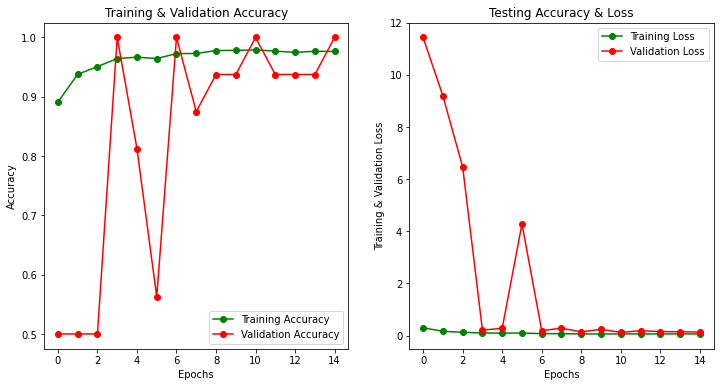

In [15]:
model = create_model()
history = model.fit(aug_train_generator, epochs=epoch_size, validation_data=val_generator, callbacks = [learning_rate_reduction], verbose=0)
score = model.evaluate(test_generator)
print("Test loss: " , score[0])
print("Test accuracy" , score[1])

create_plot(history, epoch_size)

###with balanced and augmented training set


Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 6: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.

Epoch 9: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.

Epoch 11: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.

Epoch 13: ReduceLROnPlateau reducing learning rate to 2.429999949526973e-06.

Epoch 15: ReduceLROnPlateau reducing learning rate to 1e-06.
1/1 [==============================] - 0s 177ms/step - loss: 0.2951 - accuracy: 0.9263
Test loss:  0.29505863785743713
Test accuracy 0.9262820482254028


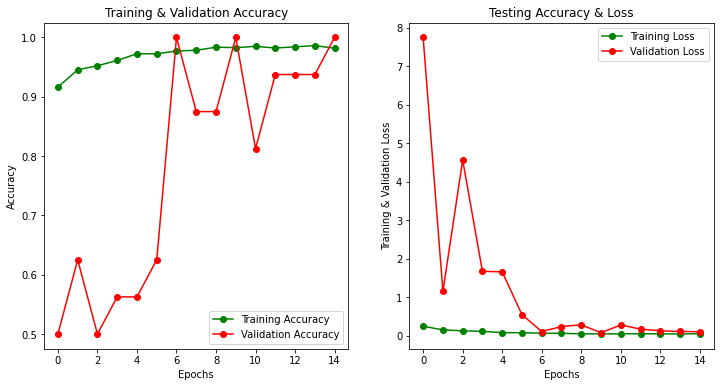

In [16]:
model = create_model()
history = model.fit(balanced_train_generator, epochs = epoch_size , validation_data = val_generator, callbacks = [learning_rate_reduction], verbose=0)
score = model.evaluate(test_generator)
print("Test loss: " , score[0])
print("Test accuracy" , score[1])

create_plot(history, epoch_size)

###without augmentation (raw training set)


Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 6: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.

Epoch 9: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.

Epoch 11: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.

Epoch 13: ReduceLROnPlateau reducing learning rate to 2.429999949526973e-06.

Epoch 15: ReduceLROnPlateau reducing learning rate to 1e-06.
1/1 [==============================] - 0s 175ms/step - loss: 1.8053 - accuracy: 0.7420
Test loss:  1.805277943611145
Test accuracy 0.7419871687889099


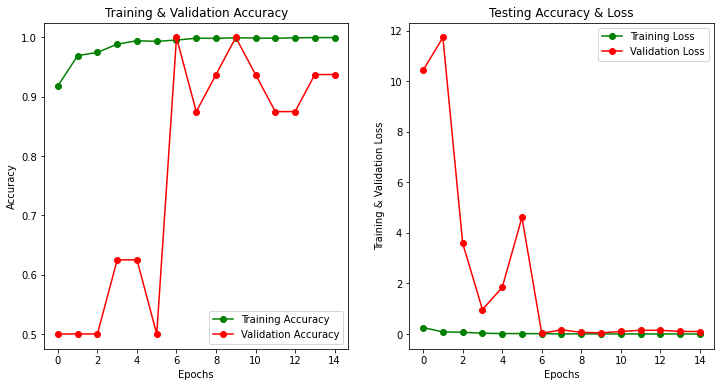

In [17]:
model = create_model()
history = model.fit(raw_train_generator, epochs = epoch_size , validation_data = val_generator, callbacks = [learning_rate_reduction], verbose=0)
score = model.evaluate(test_generator)
print("Test loss: " , score[0])
print("Test accuracy" , score[1])

create_plot(history, epoch_size)